# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, MaxPool2D, Dense, Dropout, Layer
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from typing import Tuple, Iterable, Dict, List, Callable, Optional
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [3]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:
x_train, y_train, x_test, y_test = train['X'], train['y'], test['X'], test['y']

*imshape, n_train = x_train.shape
*_, n_test = x_test.shape
dim, *_ = imshape

assert x_train.shape == (*imshape, n_train)
assert x_test.shape == (*imshape, n_test)
assert y_train.shape == (n_train, 1)
assert y_test.shape == (n_test, 1)

print('Image shape:', imshape)
print('Number of training samples:', n_train)
print('Number of testing samples:', n_test)

Image shape: [32, 32, 3]
Number of training samples: 73257
Number of testing samples: 26032


In [5]:
Sample = Tuple[np.ndarray, int]

def plot_random_samples(ncols: int, nrows: int, seed: int = 12345, train: bool = True) -> None:
    
    samples = get_random_samples(n=nrows * ncols, seed=seed, train=train)
    axs = (plt.figure(figsize=(10, 5)).subplots(nrows=nrows, ncols=ncols).flatten())

    for ax, sample in zip(axs, samples):
        plot_sample(sample, ax)

    plt.show()


def plot_sample(sample: Sample, ax) -> None:
    
    image, label = sample
    is_grayscale = (image.shape[2] == 1)
    kwargs = (dict(cmap='gray', vmin=0, vmax=255)
        if is_grayscale else {})
    ax.imshow(np.squeeze(image), **kwargs)
    ax.set_title(label)
    
def get_random_samples(n: int, seed: int = 1234, train: bool = True) -> Iterable[Sample]:
    
    rng = np.random.default_rng(seed)
    n_images = get_number_of_images_in_dataset(train=train)

    sample_indices = rng.choice(n_images, n, replace=False)
    sampler = get_sampler(train=train)
    return map(sampler, sample_indices)

def get_sampler(train: bool) -> Callable[[int], Sample]:
    
    if train:
        return get_train_sample
    else:
        return get_test_sample
    
def get_number_of_images_in_dataset(train: bool) -> int:
    if train:
        return n_train
    else:
        return n_test

def get_train_sample(index: int) -> Sample:
    assert index in range(n_train)
    return (x_train[..., index], y_train[index].item()) 

def get_test_sample(index: int) -> Sample:
    assert index in range(n_test)
    return (x_test[..., index], y_test[index].item())

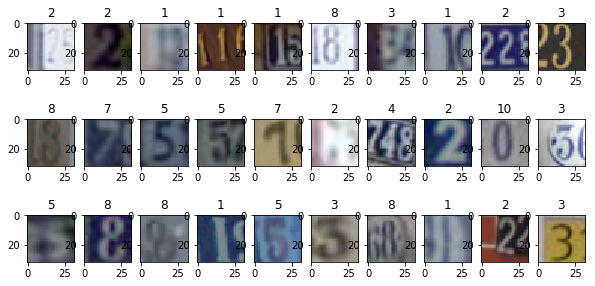

In [6]:
plot_random_samples(ncols=10, nrows=3)

In [7]:
def convert_to_grayscale(batch: np.ndarray) -> np.ndarray:
    return np.mean(batch, axis=2, keepdims=True).astype(np.uint8)

x_train = convert_to_grayscale(x_train)
x_test = convert_to_grayscale(x_test)

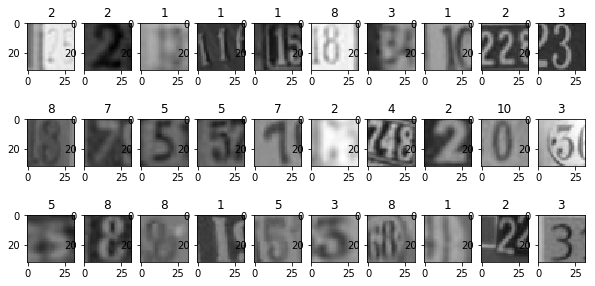

In [8]:
plot_random_samples(ncols=10, nrows=3)

In [9]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization
# We just use a fixed linear transformation here because it is easier and
# more convenient than applying the transformation by hand before feeding
# images into the network at test time.

class Standardization(Layer):

    def __init__(self, mean: float, sd: float, **kwargs):

        super().__init__(**kwargs)
        self.mean = mean
        self.sd = sd

    def call(self, inputs):
        return (inputs - self.mean) / self.sd

    
def transpose_batch_first(x):
    *size_dims, channel_dim, batch_dim = range(4)
    return np.transpose(x, (batch_dim, *size_dims, channel_dim))

def encode_target(y):
    return y - 1

def decode_target(y):
    return y + 1

In [10]:
dataset_train = (transpose_batch_first(x_train), encode_target(y_train))
dataset_test = (transpose_batch_first(x_test), encode_target(y_test))

mean = x_train.mean()
sd = x_train.std()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [11]:
def get_callbacks(model_path: str, plateau_patience: int) -> List[Callback]:

    def schedule_lr(epoch, lr):
        return lr if epoch < 6 else float(lr * tf.math.exp(-.1))

    lr_scheduler = LearningRateScheduler(schedule_lr)

    reduce_lr_on_plateau = ReduceLROnPlateau(monitor='loss', mode='min', factor=.1, patience=plateau_patience)

    checkpoint = ModelCheckpoint(filepath=f'{model_path}/checkpoint',
                                 monitor='val_accuracy',
                                 mode='max',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=True,
                                 save_freq='epoch')

    return [checkpoint, reduce_lr_on_plateau, lr_scheduler]

In [12]:
def plot_metrics(history: Dict, *metrics: str) -> None:
    
    hist = pd.DataFrame(history)
    hist = (hist.assign(epoch=hist.index.to_series() + 1).set_index('epoch'))

    fig = plt.figure(figsize=(5 * len(metrics), 5))

    axs = fig.subplots(ncols=len(metrics))
    fig.subplots_adjust(wspace=.2)

    for ax, metric in zip(axs, metrics):
        ax.set_title(metric)
        
        (hist.rename( # type: ignore
            columns={metric: 'Train',
                     f'val_{metric}': 'Validation'})
         [['Train', 'Validation']].plot(ax=ax))
        
    plt.show()

In [13]:
def visualize_model_performance(model: tf.keras.Model) -> None:

    print('Training set performance:')
    loss_train, accuracy_train = model.evaluate(*dataset_train, verbose=2)

    print('Test set performance:')
    loss_test, accuracy_test = model.evaluate(*dataset_test, verbose=2)

    ax_loss, ax_acc = plt.figure().subplots(ncols=2)

    ax_loss.bar(['Train', 'Test'], [loss_train, loss_test])

    ax_loss.set_title('Loss')

    ax_acc.bar(['Train', 'Test'], [accuracy_train, accuracy_test])

    ax_acc.set_title('Accuracy')

    ax_acc.set_ylim((0, 1))

In [14]:
class MLPDigitClassifier(Sequential):

    def __init__(self):

        super().__init__(
            [
                Standardization(mean, sd, input_shape=(dim, dim, 1)),
                Flatten(),
                Dense(512, activation='relu', kernel_regularizer=l2(.01)),
                Dense(512, activation='relu', kernel_regularizer=l2(.01)),
                Dense(265, activation='relu'),
                Dense(10, activation='softmax'),
            ]
        )

In [15]:
model = MLPDigitClassifier()
model.summary()

Model: "mlp_digit_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
standardization (Standardiza (None, 32, 32, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 265)               135945    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2660      
Total params: 926,061
Trainable params: 926,061
Non-trainable params: 0
________________________________________

In [16]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
history = model.fit(*dataset_train,
                    batch_size=128,
                    validation_split=.15,
                    epochs=30,
                    callbacks=get_callbacks(model_path='mlp_checkpoint_best',
                                            plateau_patience=3))

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62208/62268 [============================>.] - ETA: 0s - loss: 9.4515 - accuracy: 0.5104
Epoch 00001: val_accuracy improved from -inf to 0.67841, saving model to mlp_checkpoint_best/checkpoint
62268/62268 [==============================] - 55s 876us/sample - loss: 9.4484 - accuracy: 0.5106 - val_loss: 6.1836 - val_accuracy: 0.6784
Epoch 2/30
62208/62268 [============================>.] - ETA: 0s - loss: 4.5904 - accuracy: 0.7151
Epoch 00002: val_accuracy improved from 0.67841 to 0.74229, saving model to mlp_checkpoint_best/checkpoint
62268/62268 [==============================] - 52s 839us/sample - loss: 4.5894 - accuracy: 0.7151 - val_loss: 3.4098 - val_accuracy: 0.7423
Epoch 3/30
62208/62268 [============================>.] - ETA: 0s - loss: 2.7403 - accuracy: 0.7588 ETA: 2s - loss: - ETA: 1s - l
Epoch 00003: val_accuracy improved from 0.74229 to 0.76686, saving model to mlp_checkpoint_best/checkpoint
62268/62268 [=========

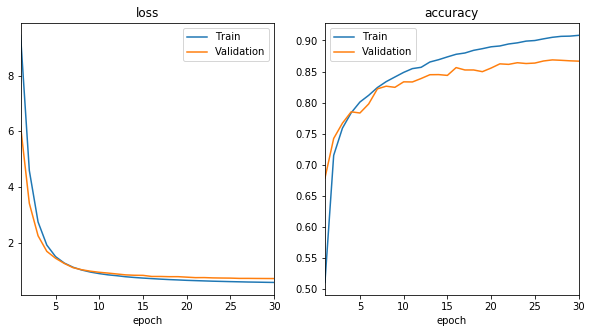

In [18]:
plot_metrics(history.history, 'loss', 'accuracy')

Training set performance:
73257/1 - 32s - loss: 0.5066 - accuracy: 0.9037
Test set performance:
26032/1 - 11s - loss: 0.7083 - accuracy: 0.8491


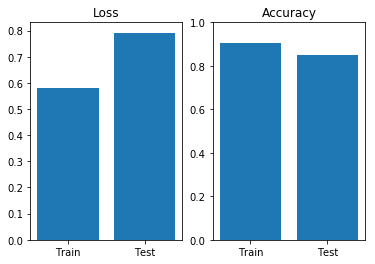

In [19]:
visualize_model_performance(model)

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [20]:
class CNNDigitClassifier(Sequential):

    def __init__(self):
        super().__init__(
            [
                *self.__get_preprocessing_layers(),
                *self.__get_conv_double_layer(32, (3, 3)),
                *self.__get_conv_double_layer(64, (3, 3)),
                Flatten(),
                *self.__get_classifier(),
            ]
        )
        
    def __get_preprocessing_layers(self) -> List[Layer]:
        return [
            Standardization(mean, sd, input_shape=(dim, dim, 1)),
            MaxPool2D((2, 2), strides=2),
        ]
    
    def __get_conv_double_layer(self, filters, kernel_size) -> List[Layer]:

        return [
            Conv2D(filters, kernel_size, padding='same', activation='relu'),
            BatchNormalization(),
            Conv2D(filters, kernel_size, padding='same', activation='relu'),
            MaxPool2D((2, 2)),
            Dropout(.4),
        ]
    
    def __get_classifier(self) -> List[Layer]:

        return [
            Dense(64, activation='relu'),
            Dense(10, activation='softmax'),
        ]

In [21]:
model = CNNDigitClassifier()
model.summary()

Model: "cnn_digit_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
standardization_1 (Standardi (None, 32, 32, 1)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 32) 

In [22]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [23]:
history = model.fit(*dataset_train,
                    batch_size=128,
                    validation_split=.15,
                    epochs=30,
                    callbacks=get_callbacks(model_path='cnn_checkpoint_best',
                                            plateau_patience=2))

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62208/62268 [============================>.] - ETA: 0s - loss: 1.5895 - accuracy: 0.4428
Epoch 00001: val_accuracy improved from -inf to 0.76076, saving model to cnn_checkpoint_best/checkpoint
62268/62268 [==============================] - 421s 7ms/sample - loss: 1.5887 - accuracy: 0.4430 - val_loss: 0.7783 - val_accuracy: 0.7608
Epoch 2/30
62208/62268 [============================>.] - ETA: 0s - loss: 0.6598 - accuracy: 0.7912
Epoch 00002: val_accuracy improved from 0.76076 to 0.86268, saving model to cnn_checkpoint_best/checkpoint
62268/62268 [==============================] - 414s 7ms/sample - loss: 0.6595 - accuracy: 0.7912 - val_loss: 0.4497 - val_accuracy: 0.8627
Epoch 3/30
62208/62268 [============================>.] - ETA: 0s - loss: 0.5154 - accuracy: 0.8400
Epoch 00003: val_accuracy improved from 0.86268 to 0.88534, saving model to cnn_checkpoint_best/checkpoint
62268/62268 [==============================] - 410s 7m

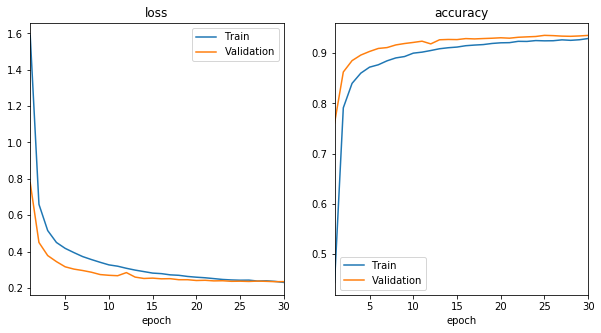

In [24]:
plot_metrics(history.history, 'loss', 'accuracy')

Training set performance:
73257/1 - 144s - loss: 0.3879 - accuracy: 0.9590
Test set performance:
26032/1 - 52s - loss: 0.1713 - accuracy: 0.9395


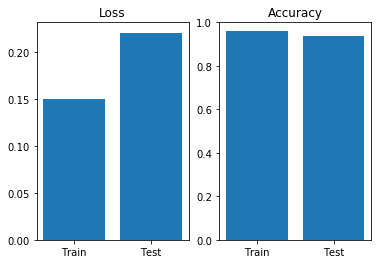

In [25]:
visualize_model_performance(model)

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [26]:
mlp_model = MLPDigitClassifier()
cnn_model = CNNDigitClassifier()

mlp_model.load_weights(filepath='mlp_checkpoint_best/checkpoint')
cnn_model.load_weights(filepath='cnn_checkpoint_best/checkpoint')

In [27]:
samples = list(get_random_samples(5, train=False))

In [28]:
 def plot_predictions(samples: List[Sample],
                      classifier: tf.keras.Model) -> None:

    fig = plt.figure(figsize=(5, 10))
    axs = fig.subplots(nrows=len(samples), ncols=2)
    fig.subplots_adjust(hspace=.5)
    fig.suptitle(classifier.__class__.__name__)
    
    for axs_row, sample in zip(axs, samples):

        ax_img, ax_pred = axs_row

        plot_sample(sample, ax_img)

        img, _ = sample
        predicted_class_probs = classifier(np.expand_dims(img, axis=0))
        ax_pred.bar(x=[str(decode_target(c)) for c in range(10)],
                    height=np.squeeze(predicted_class_probs))

        predicted_class = decode_target(np.argmax(predicted_class_probs))
        ax_pred.set_title(f'predicted: {predicted_class}')
        
    plt.show()

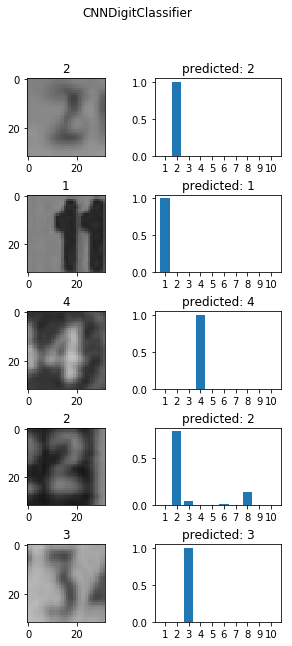

In [29]:
plot_predictions(samples, cnn_model)

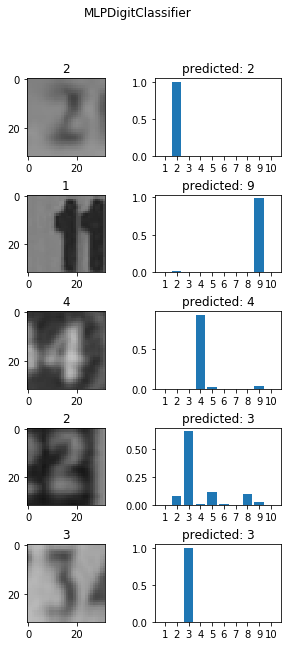

In [30]:
plot_predictions(samples, mlp_model)